# --> Importations

To start this notebook you need to download the following files.

- full_numpy_bitmap_airplane.npy
- full_numpy_bitmap_book.npy
- full_numpy_bitmap_car.npy
- full_numpy_bitmap_dog.npy
- full_numpy_bitmap_face.npy
- full_numpy_bitmap_apple.npy
- full_numpy_bitmap_brain.npy
- full_numpy_bitmap_chair.npy
- full_numpy_bitmap_eye.npy
- full_numpy_bitmap_The Eiffel Tower.npy

Then you need to store the file at the root in ./Datasets/QuickDraw.<br>

Link : https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --> Import QuickDraw dataset

In [2]:
dataset_dir = "../../Datasets/QuickDraw/"
files = os.listdir(dataset_dir)
max_size_per_cl = 1500 #maximum d'image par type d'image dans le dataset
draw_class = []
size = 0

#Evaluation de la taille du dataset
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    size += draws.shape[0]
    
#Buffer permettant de stocker les images et les targets
images = np.zeros((size, 28, 28))
targets = np.zeros((size, ))

#Itere dans la dataset et ajoute a la liste draw_class
it = 0
t = 0
for name in files:
    #Ouvre chaque dataset et creer une nouvelle classe avec un nom
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    #Ajoute les images au buffers
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    #Itere sur chaque dataset
    it += draws.shape[0]
    t += 1
    
#On change nos images en float32
images = images.astype(np.float32)
    
#Shuffle randomly
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

#Affichage de notre train set et validation set
images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)
print("Shape images : ", images.shape)
print("Shape targets : ", targets.shape)
print("\nShape valid images : ", images_valid.shape)
print("Shape valid targets : ", targets_valid.shape)
print("\nClasses possibles : ", draw_class)

Shape images :  (10050, 28, 28)
Shape targets :  (10050,)

Shape valid images :  (4950, 28, 28)
Shape valid targets :  (4950,)

Classes possibles :  ['airplane', 'apple', 'book', 'brain', 'car', 'chair', 'dog', 'eye', 'face', 'The Eiffel Tower']


# --> Exemple d'image affiche

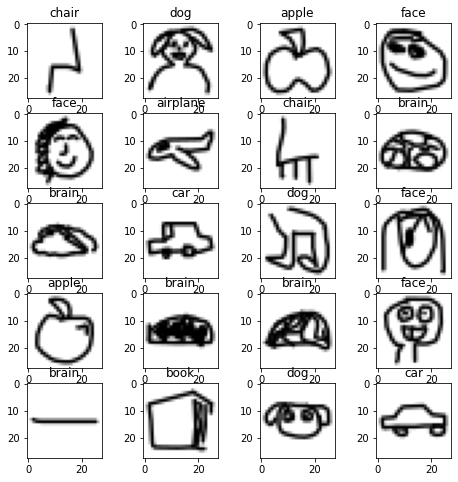

In [3]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    index = np.random.randint(len(images))     #Index d'une image aleatoire
    img = images[index]                        #On recupere cette image
    fig.add_subplot(rows, columns, i)          #Ajout d'un nouveau graph 4*5
    plt.title(draw_class[int(targets[index])]) #Ajout d'un titre par plot
    plt.imshow(img, cmap="gray")               #Affichage de l'image en noir et blanc
plt.show()

# --> Normalization

In [4]:
print("Moyenne et ecart type du dataset : ", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Moyenne et ecart type du dataset apres normalisation : ", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Moyenne et ecart type du dataset :  209.60466 85.12521
Moyenne et ecart type du dataset apres normalisation :  -8.8308555e-10 0.92857134


# --> Utilisation de tf.data

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images) #Permet de split en batch apres
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

#(10050, 28, 28, 1)
#10050 images, 28 par 28, 1 : niveau de gris
print("Shape of scaled_image : ", scaled_images.shape)

for item in train_dataset:
    print("Shape of train dataset items : ", item.shape)
    break

Shape of scaled_image :  (10050, 28, 28, 1)
Shape of train dataset items :  (28, 28, 1)


In [6]:
#Si on train le reseau sur tous le dataset, ici 10050 images on va avoir un probleme
#car il va falloir calculer le gradient avec enormement de data. Il faut donc separer
#nos data en plusieurs batch de differentes tailles.
epoch = 1 #1 epoch : ensemble des batch du dataset
batch_size = 1000
print("Batchs shape :")
for batch_training in train_dataset.repeat(epoch).batch(batch_size): #Repeat = nbr d'epoch
    #(1000, 28, 28, 1)
    #1000 : tailles du batch actuel pour le train, 28 par 28, 1 : niveau de gris
    print(batch_training.shape)

Batchs shape :
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(50, 28, 28, 1)


# --> Creation du dataset complet

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))
epoch = 1
batch_size = 1000
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print("Batch shape : ", images_batch.shape, targets_batch.shape)

Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (50, 28, 28, 1) (50,)


# --> On build notre model CNN grace a subclassing

In [8]:
class CNN(tf.keras.Model):
    
    def __init__(self):
        super(CNN, self).__init__()
        #Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation="relu", name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", name="conv3")
        #Flatten convolutions
        self.flatten = tf.keras.layers.Flatten(name="flatten")
        #Dense layers
        self.dense1 = tf.keras.layers.Dense(128, activation="relu", name="dense1")
        self.output_layer = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")
        
    def call(self, image):
        conv1 = self.conv1(image)
        #print(conv1)
        conv2 = self.conv2(conv1)
        #print(conv2)
        conv3 = self.conv3(conv2)
        #print(conv3)
        flatten = self.flatten(conv3)
        #print(flatten)
        dense1 = self.dense1(flatten)
        #print(dense1)
        output_layer = self.output_layer(dense1)
        #print(output_later)
        return output_layer
    
myCNN = CNN()
prediction = np.array(myCNN.predict(scaled_images[0:1]))
print(myCNN.summary())
print("\nOutput layer shape : ", prediction.shape)

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               multiple                  544       
_________________________________________________________________
conv2 (Conv2D)               multiple                  18496     
_________________________________________________________________
conv3 (Conv2D)               multiple                  73856     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense1 (Dense)               multiple                  7225472   
_________________________________________________________________
output_layer (Dense)         multiple                  1290      
Total params: 7,319,658
Trainable params: 7,319,658
Non-trainable params: 0
_____________________________________________________

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="valid_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_accuracy")

In [10]:
@tf.function
def train_step(image, targets):
    #Calcul du loss par rapport a une image
    with tf.GradientTape() as tape:
        predictions = myCNN(image)
        loss = loss_object(targets, predictions)
    #Calcul et utilisation du gradient
    gradients = tape.gradient(loss, myCNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, myCNN.trainable_variables))
    #Garder une idee de l'evolution
    train_loss(loss)
    train_accuracy(targets, predictions)

In [11]:
@tf.function
def valid_step(image, targets):
    #Calcul du loss par rapport a une image du validation set
    predictions = myCNN(image)
    t_loss = loss_object(targets, predictions)
    #Garder une idee de l'evolution sur le validation set
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

In [16]:
epoch = 10
batch_size = 32
b = 0
for epoch in range(epoch):
    #Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss : {}, Accuracy : {}'
        print(template.format(
                        b, 
                        len(targets), 
                        train_loss.result(), 
                        train_accuracy.result()*100
                        ), end="")
        b += batch_size
    #Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)
    template = '\n Epoch {}, Validation_Loss : {}, Validation_Accuracy : {}'
    print(template.format(
                    epoch+1, 
                    valid_loss.result(), 
                    valid_accuracy.result()*100
                    ))
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_loss.reset_states()
    train_accuracy.reset_states()

 Batch 10048/10050, Loss : 0.24217168986797333, Accuracy : 92.37413024902344
 Epoch 1, Validation_Loss : 0.523252010345459, Validation_Accuracy : 86.64646911621094
 Batch 20128/10050, Loss : 0.0321168377995491, Accuracy : 98.9452743530273477
 Epoch 2, Validation_Loss : 0.7143505811691284, Validation_Accuracy : 87.59595489501953
 Batch 30208/10050, Loss : 0.025833943858742714, Accuracy : 99.13432312011719
 Epoch 3, Validation_Loss : 0.7045199275016785, Validation_Accuracy : 88.36363220214844
 Batch 40288/10050, Loss : 0.018855223432183266, Accuracy : 99.393035888671884
 Epoch 4, Validation_Loss : 0.822877824306488, Validation_Accuracy : 87.29293060302734
 Batch 50368/10050, Loss : 0.012804251164197922, Accuracy : 99.60198974609375
 Epoch 5, Validation_Loss : 0.81531822681427, Validation_Accuracy : 87.67677307128906
 Batch 60448/10050, Loss : 0.022452715784311295, Accuracy : 99.31343078613281
 Epoch 6, Validation_Loss : 0.9204486608505249, Validation_Accuracy : 86.82828521728516
 Batch 7

In [ ]:
#On peut voir que l'train_accuracy est proche de 100%, ce qui indique probablement un overfitting
#le validation_accuracy n'augmente plus apres 86%, au dessus de cette valeur on apercoit le debut
#d'overfitting !